# Exploration Triple & Graph

## Preliminary Operations

In [28]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import ast
import matplotlib.pyplot as plt
from collections import Counter
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import seaborn as sns
import random



## Dataset Claims

In [2]:
df_triple = pd.read_csv('C:\\Users\\Simone\\Documents\\Desktop\\Tesi_Magistrale\\triple_health.csv')
df_triple.head()

,Unnamed: 0,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,triplets
0,1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,mixture,"Screening,WebMD,women's health","[{'head': 'False-Positives', 'type': 'facet of..."
1,2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,mixture,"Association/Society news release,Cancer","[{'head': 'SBRT', 'type': 'medical condition t..."
2,3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,true,"Cancer,WebMD,women's health","[{'head': 'Ovarian Cancer', 'type': 'has part'..."
3,5,8713,Britain to reveal trial criteria for coronavir...,"April 7, 2020",British regulators will this week reveal appro...,Alistair Smout,Antibody tests show whether whether people hav...,,true,Health News,"[{'head': 'coronavirus', 'type': 'has effect',..."
4,7,2768,U.S. says results encouraging for healthcare d...,"January 30, 2014",The Obama administration on Thursday reported ...,David Morgan,As part of President Barack Obama’s healthcare...,,true,Health News,"[{'head': 'healthcare delivery reforms', 'type..."


In [3]:
df_triple.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      6019 non-null   int64 
 1   claim_id        6019 non-null   object
 2   claim           6019 non-null   object
 3   date_published  4366 non-null   object
 4   explanation     6019 non-null   object
 5   fact_checkers   6018 non-null   object
 6   main_text       6010 non-null   object
 7   sources         6009 non-null   object
 8   label           6010 non-null   object
 9   subjects        6010 non-null   object
 10  triplets        6019 non-null   object
dtypes: int64(1), object(10)
memory usage: 517.4+ KB


In [4]:
# Convertiamo 'head, type & tail' come sono segnati nel grafo PREDICATE,SUBJECT_NAME,OBJECT_NAME 

# Assicurati che la colonna 'triplets' contenga liste invece di stringhe
df_triple['triplets'] = df_triple['triplets'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Applica la funzione solo alle liste non vuote
df_triple['triplets'] = df_triple['triplets'].apply(lambda triple: [{'SUBJECT_NAME': t['head'], 'PREDICATE': t['type'], 'OBJECT_NAME': t['tail']} for t in triple] if triple else [])

#Applica la funzione che rende tutto maisucolo il predicato e aggiunge il trattino basso
df_triple['triplets'] = df_triple['triplets'].apply(lambda triple: [{'SUBJECT_NAME': t['SUBJECT_NAME'], 'PREDICATE': t['PREDICATE'].upper().replace(' ', '_'), 'OBJECT_NAME': t['OBJECT_NAME']} for t in triple] if triple else [])



In [5]:
df_triple[['claim', 'label', 'triplets']]

,claim,label,triplets
0,Annual Mammograms May Have More False-Positives,mixture,"[{'SUBJECT_NAME': 'False-Positives', 'PREDICAT..."
1,SBRT Offers Prostate Cancer Patients High Canc...,mixture,"[{'SUBJECT_NAME': 'SBRT', 'PREDICATE': 'MEDICA..."
2,"Study: Vaccine for Breast, Ovarian Cancer Has ...",true,"[{'SUBJECT_NAME': 'Ovarian Cancer', 'PREDICATE..."
3,Britain to reveal trial criteria for coronavir...,true,"[{'SUBJECT_NAME': 'coronavirus', 'PREDICATE': ..."
4,U.S. says results encouraging for healthcare d...,true,[{'SUBJECT_NAME': 'healthcare delivery reforms...
...,...,...,...
6014,Venezuela expands quarantine as number of coro...,true,"[{'SUBJECT_NAME': 'quarantine', 'PREDICATE': '..."
6015,The Sturgis motorcycle rally in 2020 resulted ...,unproven,"[{'SUBJECT_NAME': 'COVID-19 coronavirus', 'PRE..."
6016,AstraZeneca's infant respiratory drug prioriti...,true,"[{'SUBJECT_NAME': 'AstraZeneca', 'PREDICATE': ..."
6017,Testicular cancer deaths double with after 40 ...,true,[{'SUBJECT_NAME': 'death double with after 40 ...


In [31]:
with pd.option_context('max_colwidth', None,):
    print(df_triple[['triplets',]])

                                                                                                                                                                                                                                                                                                                                                                                                   triplets
0                                                                                                    [{'SUBJECT_NAME': 'False-Positives', 'PREDICATE': 'FACET_OF', 'OBJECT_NAME': 'Annual Mammograms'}, {'SUBJECT_NAME': 'False-Positives', 'PREDICATE': 'PART_OF', 'OBJECT_NAME': 'Annual Mammograms'}, {'SUBJECT_NAME': 'False-Positives', 'PREDICATE': 'SUBCLASS_OF', 'OBJECT_NAME': 'False-Positives'}]
1     [{'SUBJECT_NAME': 'SBRT', 'PREDICATE': 'MEDICAL_CONDITION_TREATED', 'OBJECT_NAME': 'Prostate Cancer'}, {'SUBJECT_NAME': 'SBRT', 'PREDICATE': 'MEDICAL_CONDITION_TREATED', 'OBJECT_NAME': 'Prostate Cancer'

In [6]:
def analyze_dataset(dataset):
    subject_names = []
    object_names = []
    predicates = []

    for index, row in dataset.iterrows():
        for triplet in row['triplets']:
            subject_names.append(triplet['SUBJECT_NAME'])
            object_names.append(triplet['OBJECT_NAME'])
            predicates.append(triplet['PREDICATE'])

    # Funzione per calcolare e stampare statistiche
    def print_stats(data, title):
        data_series = pd.Series(data)
        print(f"\nStatistiche per {title}:")
        print(f"Totale: {len(data_series)}")
        print(f"Unici: {data_series.nunique()}")
        print("Prime 20 stringhe:", data_series.value_counts().head(20).index.tolist())
        print("Ultime 20 stringhe:", data_series.value_counts().tail(20).index.tolist())

    # Calcolo delle statistiche per ogni categoria
    print_stats(subject_names, 'Subject Names')
    print_stats(object_names, 'Object Names')
    print_stats(predicates, 'Predicates')

# Esempio di utilizzo della funzione:
# analyze_dataset(df_triple)



In [7]:
analyze_dataset(df_triple)


Statistiche per Subject Names:
Totale: 20270
Unici: 9218
Prime 20 stringhe: ['coronavirus', 'COVID-19', 'HIV', 'Donald Trump', 'vaccine', 'breast cancer', 'China', 'medical marijuana', 'health care', 'President', 'Medicaid', 'Planned Parenthood', 'drug', 'Barack Obama', 'Medicare', 'CDC', 'Ebola', 'United States', 'flu', 'abortion']
Ultime 20 stringhe: ['Frailty Screening', 'Shands Hospital', 'Why Tortillas May Hold The Key To Healthier Babies', 'North Dakotans', 'chronic back pain', 'breast cancer research', 'Wrestling Wonsettlers', 'Physical', 'physical', '‘infestation’', 'Florida hospital', 'RETINAL SCANS', 'probable case', 'AbbVie', 'microwave', 'drops inhaled insulin program', 'P.E.', 'school health', '1st vaping-related lung injury', 'DTaP vaccine']

Statistiche per Object Names:
Totale: 20270
Unici: 6776
Prime 20 stringhe: ['coronavirus', 'China', 'U.S.', 'COVID-19', 'President', 'cancer', 'breast cancer', 'California', 'drug', 'Trump', 'Donald Trump', 'Texas', 'United States',

In [8]:
def plot_top_items(dataset):
    def extract_items(triplets, key):
        items = []
        for index, row in dataset.iterrows():
            for triplet in row[triplets]:
                items.append(triplet[key])
        return items

    def plot_top_30(data, title):
        data_series = pd.Series(data)
        top_30 = data_series.value_counts().head(30)
        
        plt.figure(figsize=(12, 10))  # Dimensioni più grandi per il grafico
        top_30.plot(kind='bar')
        plt.title(f'Top 30 {title}')
        plt.ylabel('Frequenza')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # Estraiamo e grafichiamo per ogni categoria
    subject_names = extract_items('triplets', 'SUBJECT_NAME')
    object_names = extract_items('triplets', 'OBJECT_NAME')
    predicates = extract_items('triplets', 'PREDICATE')

    plot_top_30(subject_names, 'Subject Names')
    plot_top_30(object_names, 'Object Names')
    plot_top_30(predicates, 'Predicates')

# Esempio di utilizzo della funzione:
# plot_top_items(df_triple)



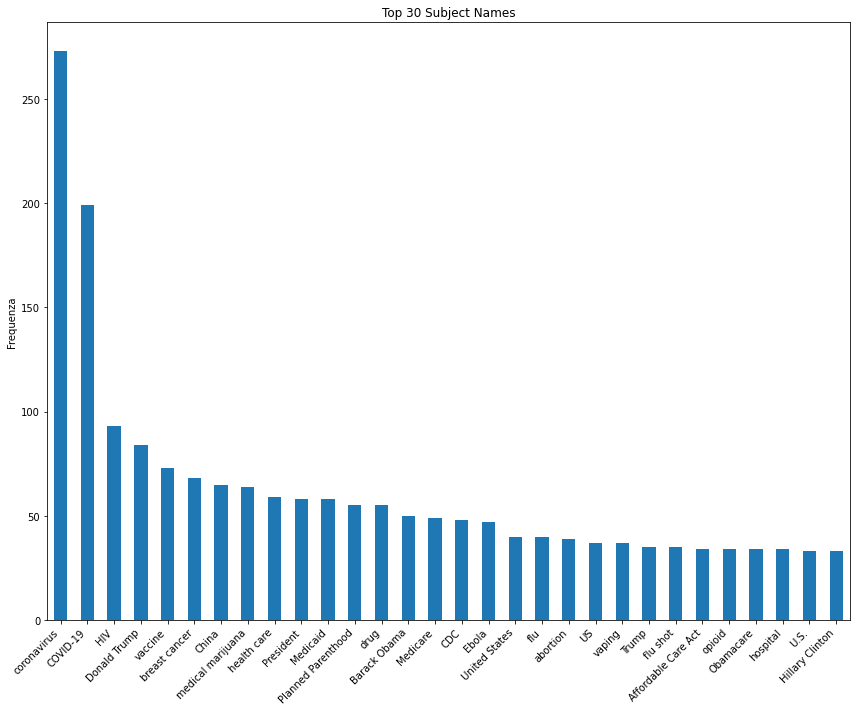

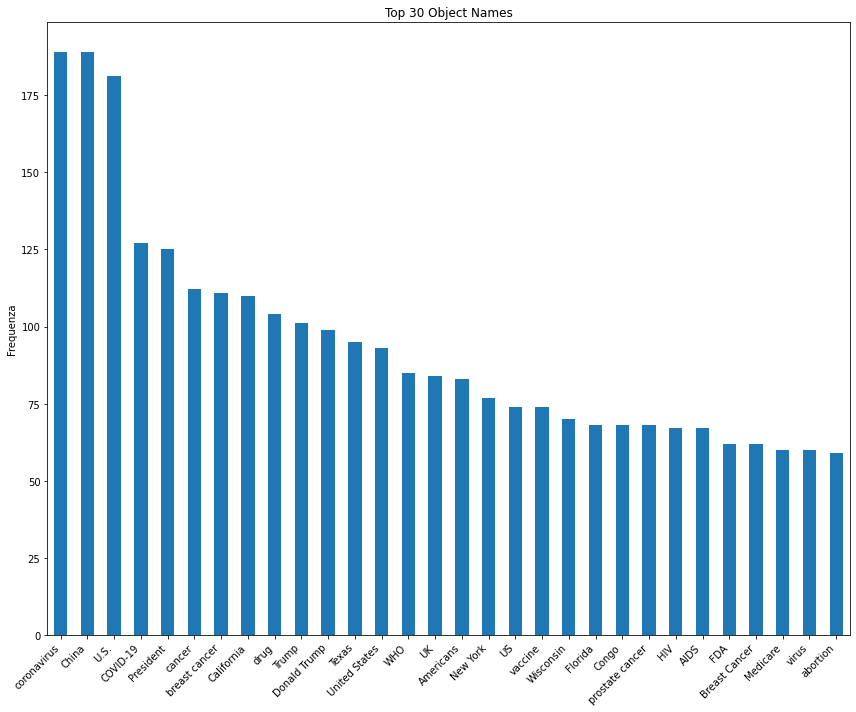

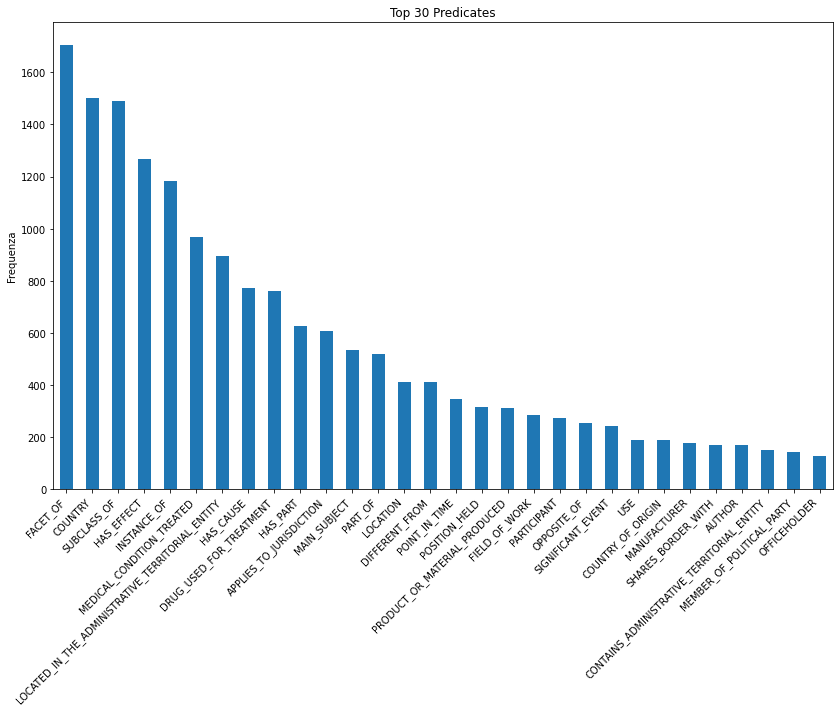

In [9]:
plot_top_items(df_triple)

In [24]:
def plot_word_frequencies(dataset):
    def extract_words(triplets, key):
        words = []
        for index, row in dataset.iterrows():
            for triplet in row[triplets]:
                words.extend(triplet[key].split())
        return words

    def plot_frequencies(data, title):
        data_series = pd.Series(data)
        frequencies = data_series.value_counts()

        plt.figure(figsize=(14, 10))
        # Per evitare un grafico sovraffollato, limitiamo il numero di parole visualizzate
        if len(frequencies) > 1000:
            print(f"Mostrando solo le prime 100 parole più frequenti su {len(frequencies)} totali.")
            frequencies = frequencies[:100]

        # Creazione del grafico scatter
        plt.scatter(frequencies.index, frequencies.values)
        plt.title(f'Frequenze delle parole per {title}')
        plt.xlabel('Parole')
        plt.ylabel('Frequenza')
        plt.xticks(rotation=90)  # Ruota le etichette sull'asse x per migliorare la leggibilità
        plt.tight_layout()
        plt.show()

    # Estraiamo e grafichiamo la distribuzione delle parole per ogni categoria
    subject_words = extract_words('triplets', 'SUBJECT_NAME')
    object_words = extract_words('triplets', 'OBJECT_NAME')
    predicate_words = extract_words('triplets', 'PREDICATE')

    plot_frequencies(subject_words, 'Subject Words')
    plot_frequencies(object_words, 'Object Words')
    plot_frequencies(predicate_words, 'Predicate Words')

# Esempio di utilizzo della nuova funzione:
# plot_word_frequencies(df_triple)



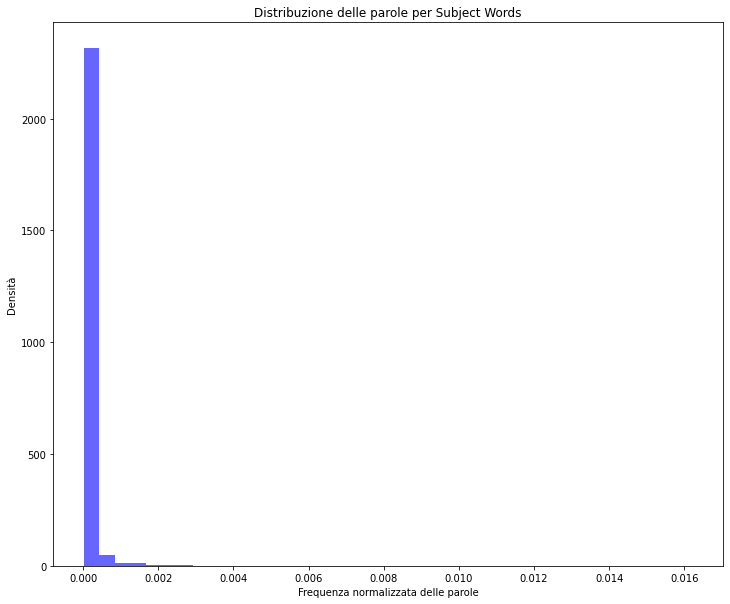

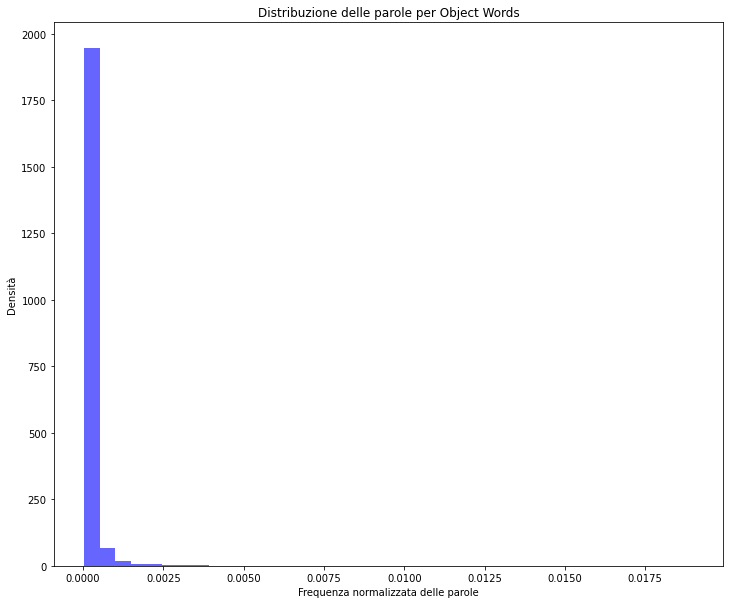

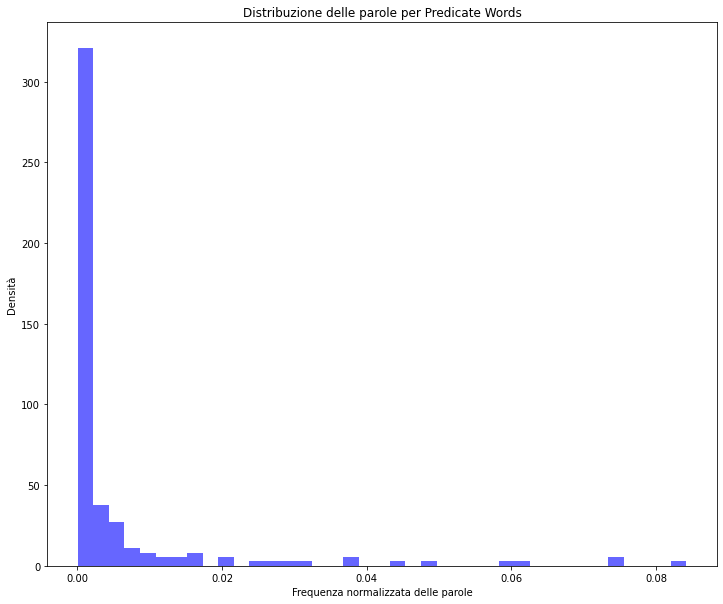

In [25]:
plot_word_distribution(df_triple)

## Dataset Knowledge Graph

In [36]:
kg = pd.read_csv('C:\\Users\\Simone\\Documents\\Desktop\\Tesi_Magistrale\\Data\\semmedVER43_2023_R_PREDICATION.csv.gz', encoding='ISO-8859-1', header=None, usecols=[3, 5, 9, 10]) #nrows=1000000
kg = kg[[3, 5, 9,10]]
nuovi_nomi_colonne = ["PREDICATE", "SUBJECT_NAME", "OBJECT_NAME","OBJECT_SEMTYPE"]  # Sostituisci con i nuovi nomi delle colonne
kg.columns = nuovi_nomi_colonne
kg.head(20)

,PREDICATE,SUBJECT_NAME,OBJECT_NAME,OBJECT_SEMTYPE
0,PROCESS_OF,Arboviruses,Lepus capensis,mamm
1,ISA,Tahyna virus,California Group Viruses,virs
2,ISA,Eyach virus,Coltivirus,virs
3,ISA,California Group Viruses,Arboviruses,virs
4,PROCESS_OF,Disease,Human,humn
5,CAUSES,Virus,Disease,dsyn
6,LOCATION_OF,Lepus capensis,Antibodies,aapp
7,PART_OF,Binding Protein,FHL1,aapp
8,PART_OF,COMPLEMENT FACTOR H|CFH,Borrelia burgdorferi,bact
9,PART_OF,Binding Protein,Borrelia burgdorferi,bact


In [37]:
def calculate_statistics(dataset):
    def print_stats(column):
        print(f"\nStatistiche per {column}:")
        print(f"Totale: {len(dataset[column])}")
        print(f"Unici: {dataset[column].nunique()}")
        print("Prime 20 stringhe:", dataset[column].value_counts().head(20).index.tolist())
        print("Ultime 20 stringhe:", dataset[column].value_counts().tail(20).index.tolist())

    for column in dataset.columns:
        print_stats(column)

# Esempio di utilizzo della funzione:
# calculate_statistics(df)


In [38]:
def plot_top_items(dataset):
    def plot_top_30(column):
        top_30 = dataset[column].value_counts().head(30)

        plt.figure(figsize=(12, 10))  # Dimensioni più grandi per il grafico
        top_30.plot(kind='bar')
        plt.title(f'Top 30 for {column}')
        plt.ylabel('Frequenza')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    for column in dataset.columns:
        plot_top_30(column)

# Esempio di utilizzo della funzione:
# plot_top_items(df)


In [39]:
calculate_statistics(kg)


Statistiche per PREDICATE:
Totale: 126268045
Unici: 68
Prime 20 stringhe: ['PROCESS_OF', 'LOCATION_OF', 'TREATS', 'PART_OF', 'ISA', 'AFFECTS', 'USES', 'COEXISTS_WITH', 'INTERACTS_WITH', 'CAUSES', 'ASSOCIATED_WITH', 'STIMULATES', 'ADMINISTERED_TO', 'INHIBITS', 'AUGMENTS', 'compared_with', 'DIAGNOSES', 'DISRUPTS', 'PRODUCES', 'PREDISPOSES']
Ultime 20 stringhe: ['same_as', 'NEG_PREVENTS', 'NEG_USES', 'NEG_METHOD_OF', 'NEG_PRECEDES', 'NEG_same_as', 'NEG_OCCURS_IN', 'NEG_higher_than', 'NEG_MEASURES', 'NEG_MANIFESTATION_OF', 'MEASUREMENT_OF', 'NEG_COMPLICATES', 'NEG_CONVERTS_TO', 'NEG_lower_than', 'NEG_MEASUREMENT_OF', 'PREP', 'NOM', 'VERB', '241', '1532']

Statistiche per SUBJECT_NAME:
Totale: 126268045
Unici: 364169
Prime 20 stringhe: ['Therapeutic procedure', 'Cells', 'Serum', 'Patients', 'Disease', 'Brain', 'Operative Surgical Procedures', 'Liver', 'Pharmaceutical Preparations', 'Body tissue', 'Lung', 'Plasma', 'Assay', 'Malignant Neoplasms', 'Obesity', 'tomography', 'Pharmacotherapy', 

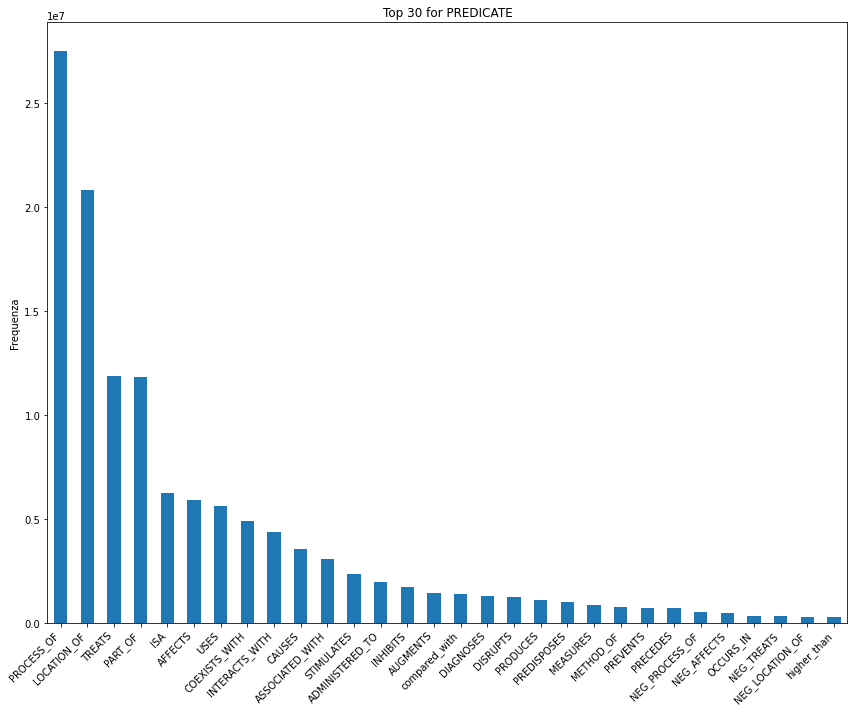

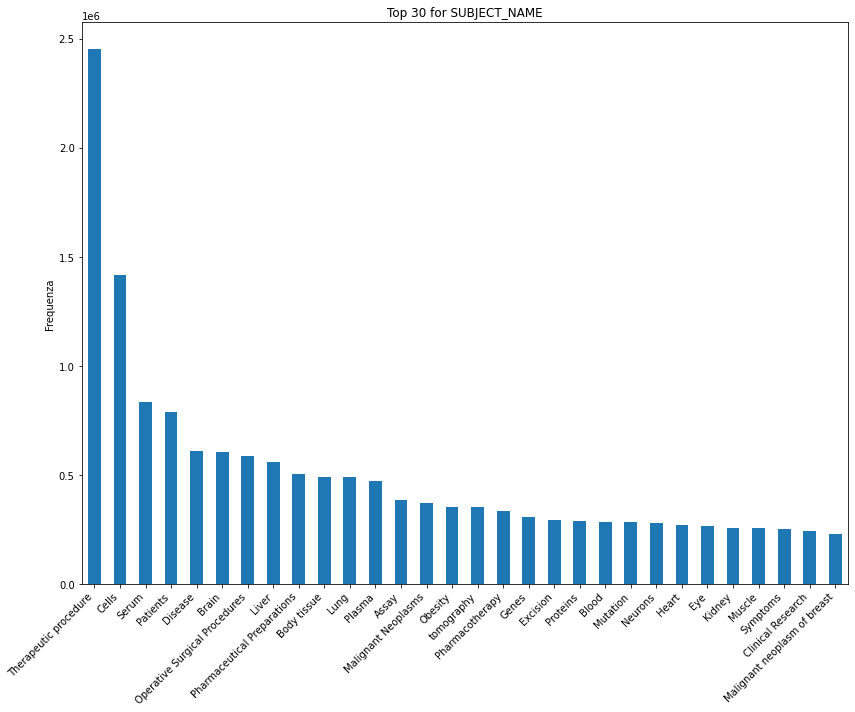

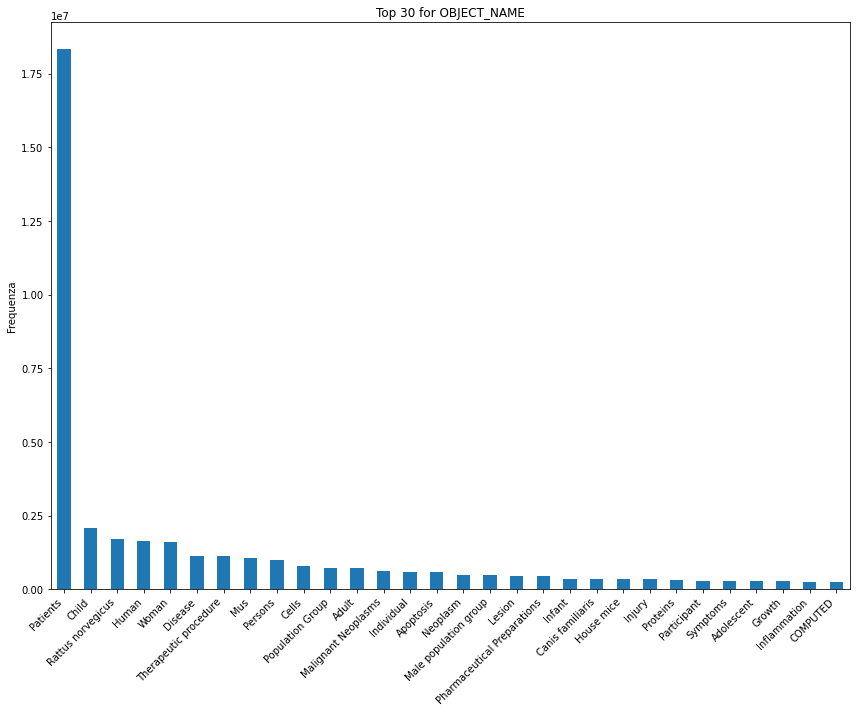

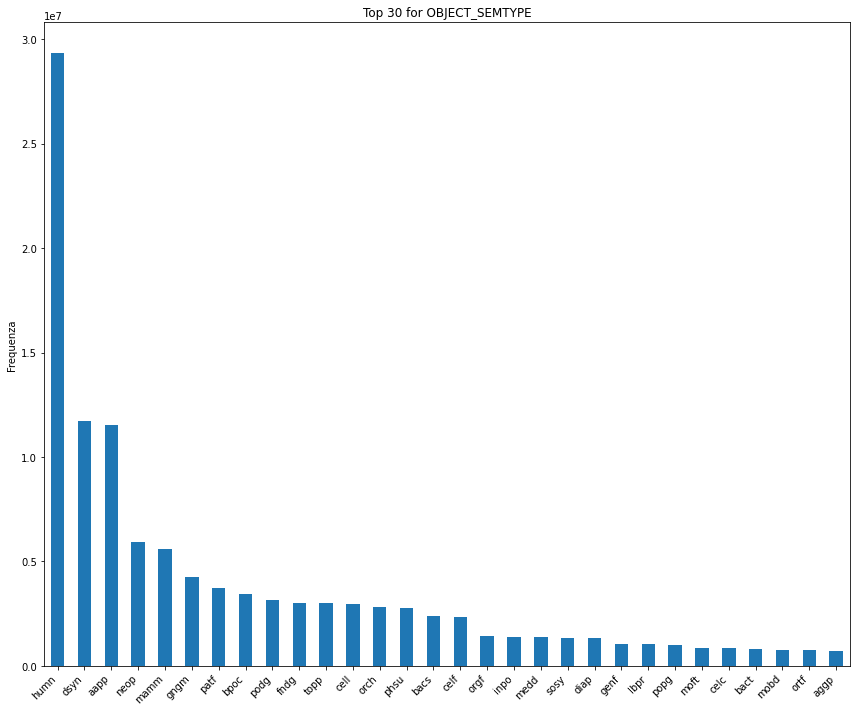

In [40]:
plot_top_items(kg)

## Knowledge Graph

In [26]:
G = pickle.load(open(r'C:\Users\Simone\Documents\Desktop\Tesi_Magistrale\KG.pickle', 'rb'))
G

In [33]:
# Creiamo un subgraph per la visualizzazione con massimo 200 nodi
nodes_of_interest = random.sample(G.nodes(), min(1000, len(G)))
subgraph = G.subgraph(nodes_of_interest)

C:\Users\Simone\AppData\Local\Temp\ipykernel_18612\3486243664.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  nodes_of_interest = random.sample(G.nodes(), min(1000, len(G)))


C:\Users\Simone\AppData\Local\Temp\ipykernel_18612\3659262932.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  nodes_of_interest = random.sample(G.nodes(), min(1000, len(G)))


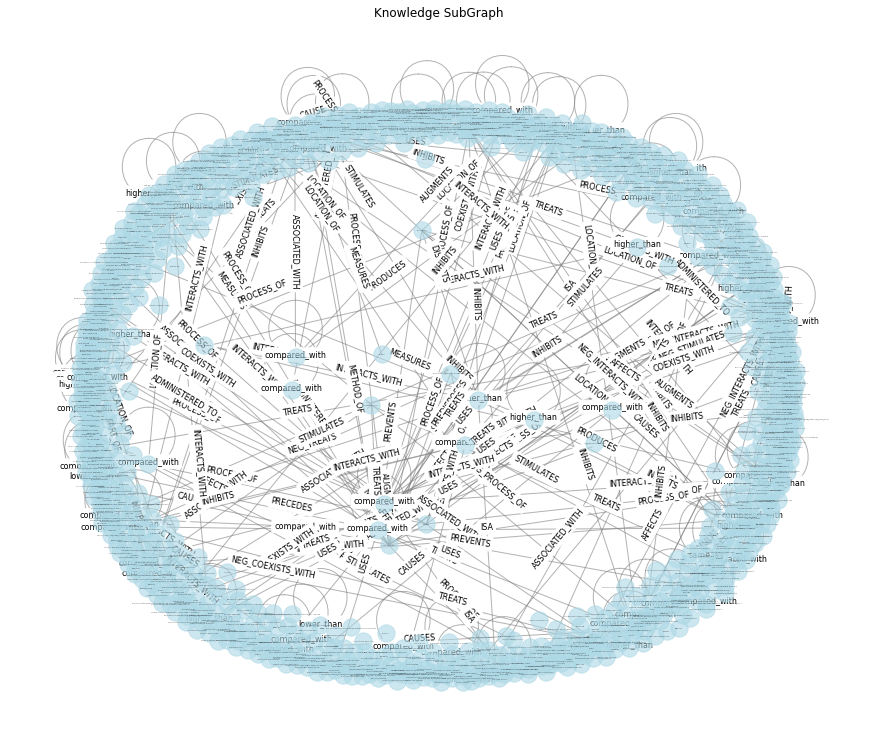

In [31]:
pos = nx.spring_layout(subgraph, seed=42, k=0.9)
labels = nx.get_edge_attributes(subgraph, 'label')
plt.figure(figsize=(12, 10))
nx.draw(subgraph, pos, with_labels=True, font_size=2, node_size=300, node_color='lightblue', edge_color='gray', alpha=0.6)
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('Knowledge SubGraph')
plt.show()

In [32]:
# Number of edges
print(G.number_of_edges())
print(len(G.nodes))

19181195
410821


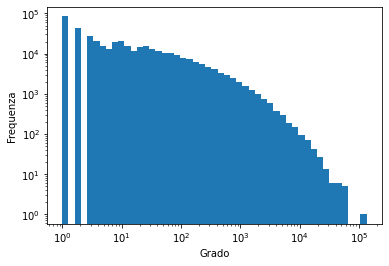

In [35]:
# Distribuzione dei Gradi
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=np.logspace(np.log10(1), np.log10(max(degrees)), 50))
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.xlabel('Grado')
plt.ylabel('Frequenza')
plt.show()

Asse X (Grado): L'asse orizzontale rappresenta il grado dei nodi su una scala logaritmica. Questo significa che ogni punto sull'asse X rappresenta una potenza di 10. Per esempio, 10^1, 10^2, 10^3, ecc.

Asse Y (Frequenza): L'asse verticale rappresenta la frequenza, ovvero quante volte un certo grado appare nel grafo, anche questo su una scala logaritmica.

Distribuzione a Coda Lunga: La curva che scende verso la destra indica che ci sono molti nodi con un grado basso e pochi nodi con un grado alto. Questo è tipico di una distribuzione a coda lunga, che è comune nei grafici di rete reale come reti sociali, reti di collaborazione, ecc.

Legge di Potenza: Il fatto che l'istogramma appaia come una linea retta in una scala log-log suggerisce che la distribuzione del grado segue una legge di potenza. Questo significa che il grafo potrebbe essere un "scale-free network", dove pochi nodi (i cosiddetti "hub") hanno molti collegamenti, mentre la maggior parte dei nodi ha pochi collegamenti.

Possibile Heterogeneità del Grafo: La presenza di hub o nodi altamente connessi indica che il grafo è eterogeneo. Questi hub possono svolgere un ruolo cruciale nella rete, agendo come ponti per la connessione di vari sottografi o per la diffusione di informazioni.

In [36]:
# Componenti Connesse
connected_components = list(nx.connected_components(G))
print(f"Numero di componenti connesse: {len(connected_components)}")

Numero di componenti connesse: 506



Quando parliamo di componenti connesse in un grafo, ci riferiamo a sottogruppi di nodi tali che all'interno di ogni sottogruppo ogni nodo è raggiungibile da ogni altro nodo del medesimo sottogruppo attraverso una sequenza di archi del grafo. In altri termini, in una componente connessa, esiste un cammino tra ogni coppia di nodi.

Nel tuo caso, il grafo contiene 506 componenti connesse distinte. Ecco cosa significa:

Numero di Componenti: Il grafo è suddiviso in 506 gruppi isolati. All'interno di ciascun gruppo, i nodi sono interconnessi, ma non ci sono collegamenti tra i gruppi.

Isolamento delle Componenti: Ogni componente connessa è indipendente dalle altre, il che significa che, basandosi sui tipi di relazioni rappresentate nel tuo grafo, alcuni concetti o entità sono raggruppati insieme ma non interagiscono o non sono correlati con elementi di altre componenti.

Analisi per Componente: Se si desidera analizzare o estrarre informazioni da questo grafo, potrebbe essere necessario trattare ogni componente connessa separatamente, in quanto rappresentano sottoinsiemi di dati che non condividono connessioni dirette.

Implicazioni Strutturali: Un alto numero di componenti connesse può suggerire che il dataset è piuttosto frammentato. Questo può essere il risultato della natura dei dati o potrebbe indicare che alcune relazioni sono mancanti o non sono state catturate nel dataset.

Importanza per il Calcolo: Per calcoli come il cammino minimo medio o altre analisi che considerano la connettività globale, potrebbe essere necessario limitarsi alla componente connessa più grande (il "giant component") per ottenere risultati significativi, poiché le altre componenti sono disconnesse da questa.

In conclusione, il grafo non è completamente connesso e presenta una notevole frammentazione. Questa informazione è utile per guidare le tue decisioni su ulteriori analisi e potenziali applicazioni dei dati rappresentati dal grafo.

In [39]:
# Centralità di Grado
# Calcola e visualizza i nodi con la più alta centralità di grado
degree_centrality = nx.degree_centrality(G)
# Ordina i nodi per centralità di grado e prendi i top 10
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodi per centralità di grado:", top_nodes)

Top 10 nodi per centralità di grado: [('Patients', 0.3247748405627769), ('Disease', 0.1508689937198773), ('Cells', 0.14645586875030425), ('Therapeutic procedure', 0.1462489654836668), ('Mus', 0.13054865878000096), ('Child', 0.12495740226863346), ('Rattus norvegicus', 0.11807117472372328), ('Woman', 0.11473151258458691), ('Human', 0.1094007107735748), ('Body tissue', 0.10526994790905993)]



La centralità di grado è una misura della rete che indica l'importanza di un nodo basata sul numero di collegamenti che ha con altri nodi. In termini semplici, un nodo con un alto grado di centralità è considerato più influente o più centrale nella rete perché può interagire con molti altri nodi.

Nel contesto del tuo grafo, la centralità di grado è stata calcolata per ogni nodo e i risultati sono stati ordinati in ordine decrescente. I "top 10 nodi per centralità di grado" sono i dieci nodi con il valore più alto di questa metrica.

Ecco una breve descrizione dei risultati che hai fornito:

'Patients' con una centralità di grado di circa 0.3248, indica che questo nodo ha il numero più alto di connessioni dirette nel grafo, facendolo diventare il nodo più centrale o importante secondo questa misura.

'Disease' segue con una centralità di grado di circa 0.1509, suggerendo che anche questo è un nodo molto connesso e gioca un ruolo centrale nel grafo, probabilmente rappresenta un concetto chiave o un soggetto comune delle relazioni nel dataset.

'Cells', 'Therapeutic procedure', 'Mus' (probabilmente riferito al genere Mus, che comprende i topi), 'Child', 'Rattus norvegicus' (un'altra specie di roditore comunemente usata nella ricerca), e 'Woman' sono tutti nodi con alta centralità, indicando che sono soggetti o concetti che hanno molte relazioni con altre entità nel grafo.

La centralità di grado è stata normalizzata, e i valori che vedi rappresentano la proporzione di nodi nel grafo a cui ogni nodo è collegato direttamente. Ad esempio, un valore di centralità di 0.3248 per 'Patients' significa che 'Patients' è collegato direttamente a circa il 32.48% di tutti gli altri nodi nel grafo.

Questi nodi possono essere visti come punti di interesse chiave all'interno del grafo per ulteriori analisi, potenzialmente agendo come ponti principali per la diffusione di informazioni o come nodi focali in studi di rete. Se il tuo grafo rappresenta una rete di conoscenza nel campo della biologia o della medicina, questi nodi potrebbero rappresentare aree di intensa ricerca e pubblicazione o concetti che sono centrali in molte condizioni, trattamenti o studi scientifici.

In [41]:
assortativity = nx.degree_assortativity_coefficient(G)
print(f"Assortatività del grafo: {assortativity}")

Assortatività del grafo: -0.544145723954869


In [43]:
# Calcola il coefficiente di clusterizzazione per ciascun nodo
clustering_coefficients = nx.clustering(G)
# Per visualizzare solo alcuni nodi, per esempio i primi 5
for node, coeff in list(clustering_coefficients.items())[:5]:
    print(f"Nodo: {node}, Coefficiente di clusterizzazione: {coeff}")

# Coefficiente di clusterizzazione medio del grafo
average_clustering = nx.average_clustering(G)
print(f"Coeficiente di clusterizzazione medio: {average_clustering}")


KeyboardInterrupt: 

In [40]:
# Cammino Minimo Medio (su una componente connessa o un campione)
# Questo può essere molto costoso in termini di tempo su grafici grandi, quindi considera di lavorarci su un sottografo o usa un approccio approssimativo
if len(connected_components) > 0:
    largest_cc = max(connected_components, key=len)
    subgraph = subgraph.subgraph(largest_cc)
    average_shortest_path_length = nx.average_shortest_path_length(subgraph)
    print(f"Lunghezza media del cammino minimo: {average_shortest_path_length}")

KeyboardInterrupt: 